In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-histopathology-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7415%2F10564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T125647Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9eeff7fe637e5823455127a72febf8a81ce1bb8cc6277b9ab0c0e6155805df2e4c88e8b5eb61812aa939c36f1b33c1e58b16e3f14165238ddc34422c5b0a0a71369d33e31d256cb543ec174030e9cabd6b312961454ff39a046ff1c9e2a6b52ef159c99188bd3b0e32a7893f9f23d6a8c3ce5d0a42fd61f5b6f09f35702ca08da82e95489206fe7fc528648f6110457646356637366f824eeb191fad5a21ee736bfae563ccfd9da8a66d4ba810e3dbe7ca7a30b1d013f3f861bc0f790ca26f502828ea4de4a8a7d610d5f516c827a14502cf488ba7d2fc143b36158fdb2d48557dc7661ab8b44e0697a4236a5da4d74cc4914ec09b4c99d8ef0ad1eca5675e3e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


## Breast Cancer Dedection Using CNN

This notebook how deep learning methods, particularly convolutional neural networks (CNNs), can be leveraged to improve the accuracy of breast cancer diagnosis using histopathological images. By optimizing these techniques, we aim to enable earlier detection and minimize the devastating impact of this disease.
Accurate and early diagnosis of breast cancer can significantly improve patient outcomes and reduce the physical and mental toll of the disease.
Globally, breast cancer claims the lives of 670,000 people annually and affects 2.3 million women, underscoring the urgent need for enhanced diagnostic tools.


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import PIL
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Rescaling
import glob
import cv2

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l2
import itertools

## Loading Data

In [ ]:
# Create the dataset
dataset = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png',recursive = True)


In [ ]:
for img in dataset[:3]:
    print(img)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


In [ ]:
## The number of images we have

len(dataset)

277524

In [ ]:
# The number of patients
# Folder counts show the number of patients

basepath = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder_count = os.listdir(basepath)
len(folder_count)

279

## Visualization

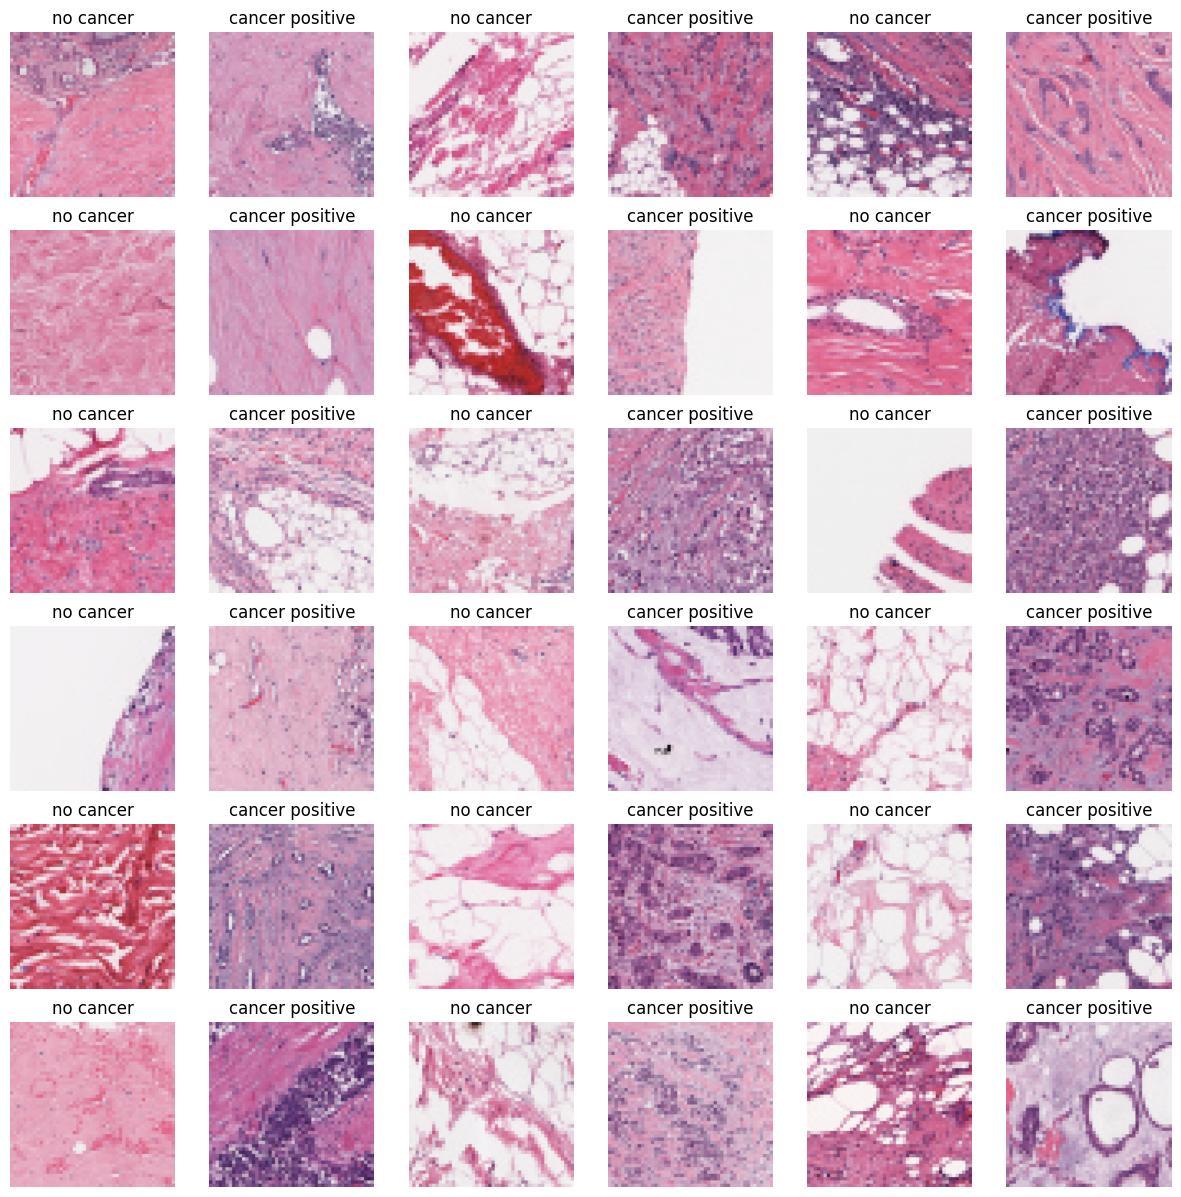

In [ ]:
negative_idc = []
positive_idc = []

for img in dataset:
    if img[-5] == '0' :
        negative_idc.append(img)

    elif img[-5] == '1' :
        positive_idc.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(negative_idc), 18)
some_can = np.random.randint(0, len(positive_idc), 18)

s = 0
for num in some_non:

        img = image.load_img((negative_idc[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((positive_idc[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('cancer positive')
        plt.imshow(img.astype('uint8'))
        s += 1


In [ ]:

print(len(negative_idc))
print(len(positive_idc))

198738
78786


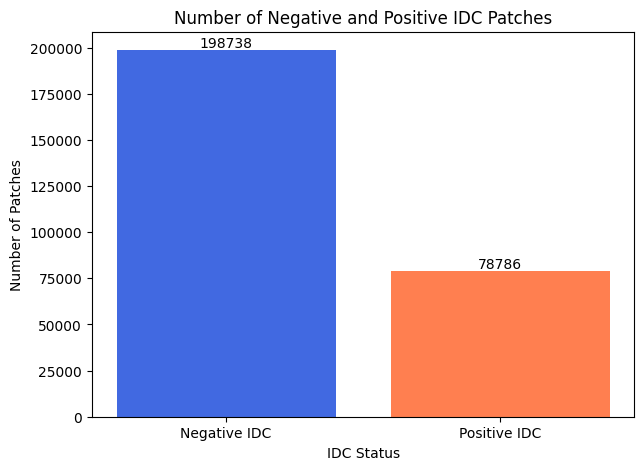

In [ ]:
## Categories positive idc or negative idc

num_negative_idc = len(negative_idc)
num_positive_idc = len(positive_idc)


categories = ['Negative IDC', 'Positive IDC']
counts = [num_negative_idc, num_positive_idc]

# Graph
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(categories, counts, color=['RoyalBlue', 'coral'])


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

ax.set_xlabel('IDC Status')
ax.set_ylabel('Number of Patches')
ax.set_title('Number of Negative and Positive IDC Patches')

plt.show()

Since the number of negative idc are more than the number of positive idc shows us imbalanced class problem. This needs to be solved before modelling.

## Under-Sampling

In [ ]:
## Under-Sampling
## Keeping X and y separate and under-sampling.
## The number of images are decreased from 277542 to 40057.

total = len(negative_idc) + len(positive_idc)
ppos = len(positive_idc)/total
desired = 40000
psamp = desired/total
print(total, ppos, desired, psamp)

non_img_arr = []
can_img_arr = []
non_y = []
can_y = []

for i,img in enumerate(negative_idc):
    if (np.random.uniform() < psamp):
      n_img = cv2.imread(img, cv2.IMREAD_COLOR)
      n_img = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      non_img_arr.append(n_img)
      non_y.append(0)

for i,img in enumerate(positive_idc):
    if (np.random.uniform() < psamp):
      c_img = cv2.imread(img, cv2.IMREAD_COLOR)
      c_img = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      can_img_arr.append(c_img)
      can_y.append(1)

X = np.concatenate((non_img_arr, can_img_arr))
y = np.concatenate([non_y,can_y])

277524 0.28388896095472826 40000 0.14413167870166183


In [ ]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 39982
Number of IDC(-) Images: 28662
Number of IDC(+) Images: 11320
Image shape (Width, Height, Channels): (50, 50, 3)


## Train-Test Splitting

In [ ]:
## Train-Test Splitting

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (27987, 50, 50, 3)
Testing Data Shape: (11995, 50, 50, 3)


## Modelling

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5) #Early Stopping

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            5

 Total params: 2,514,410 (9.59 MB)

 Trainable params: 2,513,642 (9.59 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Model Training


history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=35)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 235s 285ms/step - accuracy: 0.7800 - loss: 5.4326 - val_accuracy: 0.8164 - val_loss: 3.4759
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 223s 278ms/step - accuracy: 0.8361 - loss: 3.0152 - val_accuracy: 0.7756 - val_loss: 2.0762
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 220s 275ms/step - accuracy: 0.8507 - loss: 1.7376 - val_accuracy: 0.8238 - val_loss: 1.2473
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 220s 275ms/step - accuracy: 0.8531 - loss: 1.1002 - val_accuracy: 0.8038 - val_loss: 0.9273
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 221s 276ms/step - accuracy: 0.8498 - loss: 0.7807 - val_accuracy: 0.8207 - val_loss: 0.7071
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 220s 274ms/step - accuracy: 0.8547 - loss: 0.6036 - val_accuracy: 0.8210 - val_loss: 0.5798
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 221s 276ms/step - accuracy: 0.8564 - loss: 0.5022 - val_accuracy: 0.8048 - val_loss: 0.5395
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 221s 276ms/step - accuracy: 0.8604 -

## Model Evaluation

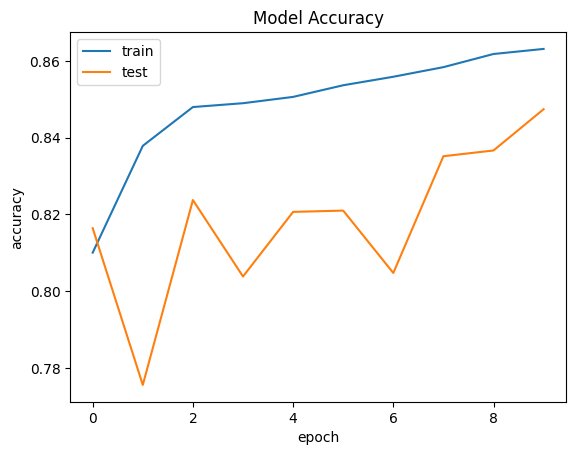

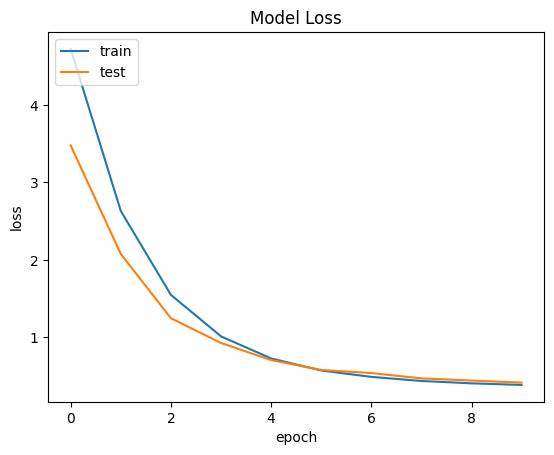

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step


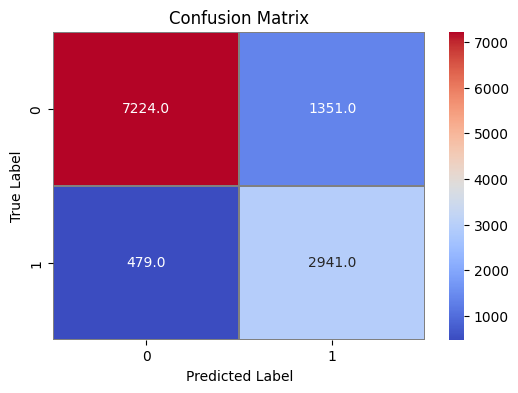

In [ ]:
# Predicted Values
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Confusion matrix visualization
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="coolwarm", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.evaluate(X_test,Y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8459 - loss: 0.4157


[0.4163160026073456, 0.8474364280700684]

## Checking

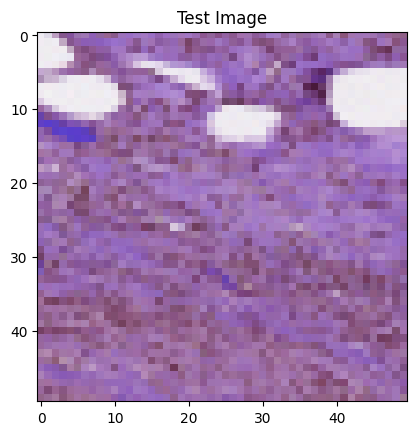

In [ ]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 1
img_plot(X_test, index)

In [ ]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 1
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Value using  cnn model 1
True Value 0


The application of deep learning methods is a challenging task from understanding the dataset to preparing and modelling it. In this notebook, the stages of this challenging tasks were carried out using the Breast Histopathology Images dataset. The dataset was first visualized and positive and negative patches were categorized. Subsequently, the under-sampling method was used to solve the imbalanced class problem. Finally, a complicated model was built based on the CNN method, the training of the model was completed and the model was tested. Although the results obtained are successful, different results may be obtained in the future with different deep learning models or hybrid models, different parameter values, different epoch numbers for the same dataset.